## <center> 数据挖掘第二次课程作业 <center>
####     <p style="text-align:right"> 吴嘉豪   _3220190894_ </p>
## 数据关联分析与处理 
### 1. python库引入

引入需要使用的函数 ： 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules
from mlxtend.plotting import stacked_barplot,scatterplotmatrix

%matplotlib inline
%config InlineBackend.figure_format='svg'
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False


## 2. 处理数据集 - Wine Reviews

__1. 数据集分析:__   
该数据集是对于葡萄酒的品鉴结果收集集,两个数据集中记载了130k与150k的葡萄酒品鉴评论,其中第二个数据集为作者后来重新爬取的结果，这次爬取中作者额外收集了每个评论的标题、年份、品酒者的姓名和品酒者的Twitter句柄，并解决了重复输入的问题，这里对Wine Review进行数据的关联分析，因此这里主要处理的是winemag-data-130k-v2.csv。  
该数据集中属性包含有：country \ description \ designation \ points \ price \ province \ region_1 \ region_2 \ taster_name \ taster_twitter_handle \ title \ variety \ winery, 并给出了各个属性的描述，这也是我第一次作业中所处理的数据集对象。

In [2]:
data_dir_cbd = r"F:\course\web\data\wine-reviews"
cdb_data_main = pd.read_csv(data_dir_cbd + "\winemag-data-130k-v2.csv")
# cdb_data_old = pd.read_csv(data_dir_cbd + "\winemag-data_first150k.csv")
# print(cdb_data.head())

__2. 缺省值的补充:__  
这里主要是实现对数值数据中缺省值的补充，而从上面已经得知主要缺失的是Price数据，因此下面使用上面提及到的四种方法对该缺省值进行填充。  
为了后续关联性分析的处理方便，我们通过数据对象之间的相似性来填补Price数据项中的缺失值。 

In [3]:
price = cdb_data_main["price"]
price_D = price.copy()
price_nan_index = np.where(price.isnull().values==True)[0]
variety_D = cdb_data_main["variety"]
designation_D = cdb_data_main["designation"]
for i in price_nan_index:
    variety_i = variety_D[i]
    designation_i = designation_D[i]
    v_poss = np.where(variety_D == variety_i)
    d_poss = np.where(designation_D == designation_i)
    and_index = list(set(v_poss[0]) & set(d_poss[0]) - set(list(price_nan_index)))
    if and_index != []:
        k = random.sample(and_index , 1)
        price_D[i] = price_D[k]
        continue
    v_index = list(set(v_poss[0]) - set(list(price_nan_index)))
    if v_index != []:
        k = random.sample(v_index , 1)
        price_D[i] = price_D[k]
        continue
    d_index = list(set(d_poss[0]) - set(list(price_nan_index)))
    if d_index != []:
        k = random.sample(d_index , 1)
        price_D[i] = price_D[k]
        continue
    ran_index = list(set(np.arange(0,len(price_D))) - set(list(price_nan_index)))
    k = random.sample(ran_index , 1)
    price_D[i] = price_D[k]
print("D方法处理之后NaN个数 ：" ,len(price_D) - len(price_D.dropna()))
cdb_data_main["price"] = price_D

D方法处理之后NaN个数 ： 0


In [4]:
print("Designation类别数：",len(cdb_data_main["designation"].value_counts()))
print("Winery类别数：",len(cdb_data_main["winery"].value_counts()))
print("Variety类别数：",len(cdb_data_main["variety"].value_counts()))
# print(cdb_data_main)

Designation类别数： 37979
Winery类别数： 16757
Variety类别数： 707


针对于频繁项集而言，认为winery,designation项类别过多，因此不纳入候选项集，鉴于同样的判断，最终的候选项集中涉及的项集有country,province,variety,points,price这几项，并在下面进行数据集的转化。

__3. 数据集转化:__  
对于points与price这样的数值数据，通过数值数据的离散化进行分层：  
__Points:__ 对于points数据而言，根据其数据的箱图，针对其得分区间进行划分为Poor[80-85] \ Acceptable[85-90] \ Exceeds Expectations[90-95] \ Outstanding[95-100],上面的区间皆为左开右闭区间，并分别以其首字母为标记。  
__Price:__ 对于price数据而言，根据其数据的箱图和分位数，针对价格区间进行划分为Extreme cheap[-6] \ Cheap[6-17] \ Relatively Cheap[17-25] \ Relatively Expensive[25-42] \ Expensive[42-75] \Extreme Expensive [75-],上面的区间皆为左开右闭区间，并分别以其部分首字母为标记。

In [5]:
points_bin=[min(cdb_data_main["points"]),85,90,95,max(cdb_data_main["points"])]
cdb_data_main["points_new"] = pd.cut(cdb_data_main["points"],points_bin,labels=['P','A','E','O'])
print("Points离散化映射:")
print(cdb_data_main["points_new"].value_counts())

price_bin=[min(cdb_data_main["price"]),6,17,25,42,75,max(cdb_data_main["price"])]
cdb_data_main["price_new"] = pd.cut(cdb_data_main["price"],price_bin,labels=['ECh','Ch','RCh','REx','Ex','EEx'])
print("Price离散化映射:")
print(cdb_data_main["price_new"].value_counts())

item_list = cdb_data_main[["country","province","variety","points_new","price_new"]].dropna(subset=["country","province","variety","points_new","price_new"])
# print(item_list)
item_list.to_csv("F:\\course\\web\\data\\item_wine.csv")

Points离散化映射:
A    74376
E    32754
P    21563
O      881
Name: points_new, dtype: int64
Price离散化映射:
Ch     33692
REx    31850
RCh    31679
Ex     23998
EEx     8567
ECh      174
Name: price_new, dtype: int64


In [6]:
item_set = pd.read_csv("F:\\course\\web\\data\\item_wine.csv",index_col=0)
item_list = item_set.values.tolist()
print("候选项集示例:")
print("第一项记录:" , item_list[0])
print("第二项记录:" , item_list[1])
print("第三项记录:" , item_list[2])

候选项集示例:
第一项记录: ['Italy', 'Sicily & Sardinia', 'White Blend', 'A', 'Ch']
第二项记录: ['Portugal', 'Douro', 'Portuguese Red', 'A', 'Ch']
第三项记录: ['US', 'Oregon', 'Pinot Gris', 'A', 'Ch']


__将候选项集转化为合适的数据格式:__

In [7]:
Transform = TransactionEncoder() 
te_ary = Transform.fit(item_list).transform(item_list) 
trans_set = pd.DataFrame(te_ary, columns=Transform.columns_) 
trans_set

,A,Abouriou,Achaia,Aconcagua Costa,Aconcagua Valley,Aegean,Agiorgitiko,Agioritikos,Aglianico,Ahr,...,Zierfandler-Rotgipfler,Zinfandel,Zlahtina,Zweigelt,Çalkarası,Österreichischer Perlwein,Österreichischer Sekt,Štajerska,Žilavka,Župa
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129494,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
129495,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
129496,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
129497,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


__4. 计算频繁项集:__  
使用剪枝的Apriori算法，并且在计算过程之中将频繁项集的support率设定为0.0772 (Corresponding therhold:10000)，可以得到如下的频繁项集结果：

In [8]:
fre_itemlist = apriori(trans_set, min_support=0.0772, use_colnames=True)
fre_itemlist

,support,itemsets
0,0.573966,(A)
1,0.278867,(California)
2,0.258041,(Ch)
3,0.090364,(Chardonnay)
4,0.252828,(E)
5,0.185252,(Ex)
6,0.170488,(France)
7,0.150851,(Italy)
8,0.166403,(P)
9,0.102341,(Pinot Noir)


__5. 关联规则探索与分析:__

首先对上面找出的频繁项进行计算，找出其所对应confidence>0.6的所有频繁项并将其计算为关联规则，其对应的计算结果如下表所示：

In [9]:
rules_conf = association_rules(fre_itemlist, metric="confidence", min_threshold=0.6)
rules_conf[["antecedents","consequents","support","confidence"]]

,antecedents,consequents,support,confidence
0,(Ch),(A),0.157206,0.609229
1,(Italy),(A),0.102472,0.679294
2,(RCh),(A),0.172001,0.705476
3,(REx),(A),0.148117,0.603423
4,(California),(US),0.278867,1.000000
5,(US),(California),0.278867,0.664550
6,"(California, A)",(US),0.144009,1.000000
7,"(A, US)",(California),0.144009,0.627490
8,"(California, E)",(US),0.083977,1.000000
9,"(E, US)",(California),0.083977,0.712367


计算给出了如上面这样的十二条关联规则，并可以对其进行一定的探索。
1. 对于0、1、4这三条关联规则而言，当wine的价位是在位于Relative Cheap / Cheap / Relative Expensive这三个档之间时，通常会得到Acepctable的评价结果，这也是与我们认知相吻合的。
2. 对于4、5、6、8、10而言，我们可以看出明显的内在关系是California是属于US的，因此由California项导出US想也是理所应当的，这一点从这些规则的置信度为一这一点就能清楚地看出。
3. 对于该表之中的其他国家与地区间的关系，实际上也同样应该在关联记录中有所反映，而这里实际上因为support的阈值问题(部分项的记录数过少)，而没有体现出来，可以调节上面的support_min进行查看。
4. 而对于另外几条规则而言，实际上可以看出一些信息。对于2来说我们可以说关联分析认为意大利的wine通常会是Acceptable的，而从弟5条中可以看出记录中许多美国的wine都来自于加州。7、9则可以看出在美国生产的E/A的酒(评分较好)很可能会来自于加州。
5. 类似的，从最后一条记录中我们可以看出在美国生产的酒并且较贵的将大概率来自于加州。

In [10]:
more_freitemlist = apriori(trans_set, min_support=0.01, use_colnames=True)

In [11]:
more_rules = association_rules(more_freitemlist, metric="confidence", min_threshold=0.80)
more_rules[["antecedents","consequents","support","confidence"]]

,antecedents,consequents,support,confidence
0,(Alsace),(France),0.018796,1.000000
1,(Mendoza Province),(Argentina),0.024672,1.000000
2,(Argentina),(Mendoza Province),0.024672,0.858179
3,(South Australia),(Australia),0.010409,1.000000
4,(Bordeaux),(France),0.045861,1.000000
...,...,...,...,...
169,"(Nebbiolo, Ex, Piedmont)",(Italy),0.010880,1.000000
170,"(Piedmont, Italy, Ex)",(Nebbiolo),0.010880,0.945638
171,"(Nebbiolo, Ex)","(Piedmont, Italy)",0.010880,0.972395
172,"(Piedmont, Ex)","(Nebbiolo, Italy)",0.010880,0.945638


为了进一步的证实上面所说的推测，在这里另外通过将频繁模式的阈值降低到(0.01)后在计算相对应的关联规则与置信度，这里可以看到由此能够得到上面那样的更多的country与province的对应关联规则。

__6. 关联规则评价:__

__Leverage:__ 在得到上面的十二条规则之后，对其进行关联规则的评价，其评价规则除了上课中提及的Lift、All_conf、Kulc和Cosine之外，还有该库中自带的leverage评价，改评价方法的计算过程如下：

<center> $ levarage(A→C)=support(A→C)−support(A)×support(C),range: [−1,1] $
 
即对应计算观察到的A和C一起出现的频率减去A和C独立的预期频率之间的差。

In [12]:
rules_eva = association_rules(fre_itemlist, metric="confidence", min_threshold=0.60)
# rules_eva[["antecedents","consequents","support","confidence","lift"]]
# print(rules_eva)
sup_antecedent = rules_eva["antecedent support"]
sup_consequent = rules_eva["consequent support"]
sup_co = rules_eva["support"]
confidence = rules_eva["confidence"]

# kulc all_conf cosine 评价的计算
rev_confidence = sup_co / sup_consequent
all_conf = pd.DataFrame(list(zip(confidence,rev_confidence))).max(axis=1)
kulc = (confidence + rev_confidence)/2
consine = np.sqrt(confidence * rev_confidence)
rules_eva["All_conf"] = all_conf
rules_eva["Kulc"] = kulc
rules_eva["Cosine"] = consine
rules_eva[["antecedents","consequents","support","confidence","lift","All_conf","Kulc","Cosine","leverage"]]

,antecedents,consequents,support,confidence,lift,All_conf,Kulc,Cosine,leverage
0,(Ch),(A),0.157206,0.609229,1.061438,0.609229,0.441562,0.408490,0.009099
1,(Italy),(A),0.102472,0.679294,1.183509,0.679294,0.428913,0.348247,0.015889
2,(RCh),(A),0.172001,0.705476,1.229126,0.705476,0.502574,0.459795,0.032063
3,(REx),(A),0.148117,0.603423,1.051322,0.603423,0.430741,0.394612,0.007231
4,(California),(US),0.278867,1.000000,2.383037,1.000000,0.832275,0.815200,0.161845
5,(US),(California),0.278867,0.664550,2.383037,1.000000,0.832275,0.815200,0.161845
6,"(California, A)",(US),0.144009,1.000000,2.383037,1.000000,0.671589,0.585814,0.083578
7,"(A, US)",(California),0.144009,0.627490,2.250140,0.627490,0.571948,0.569245,0.080009
8,"(California, E)",(US),0.083977,1.000000,2.383037,1.000000,0.600061,0.447349,0.048738
9,"(E, US)",(California),0.083977,0.712367,2.554506,0.712367,0.506753,0.463164,0.051103


上面给出了上面十一条关联规则所对应的Lift / All_conf / Cosine与leverage所对应给出的评价。由这些评价可以看出对应的关联规则的重要性是比较一致的。

__7. 关联规则评价可视化:__

这一部分将给出上述关联规则的可视化与其对应的评价

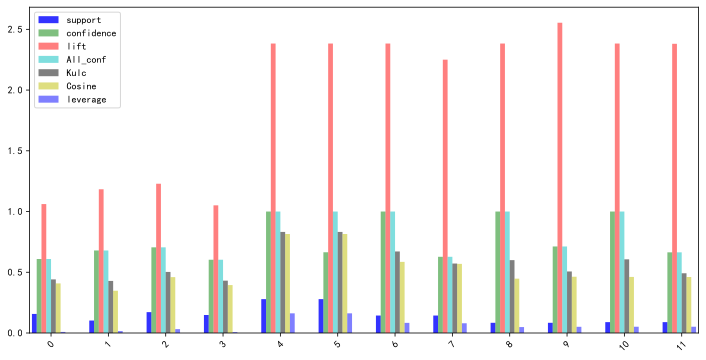

In [13]:
rule_bar = rules_eva[["support","confidence","lift","All_conf","Kulc","Cosine","leverage"]]
fig = stacked_barplot(rule_bar, rotation=45, legend_loc='best')

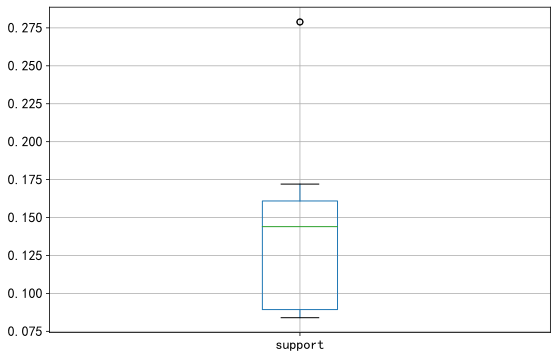

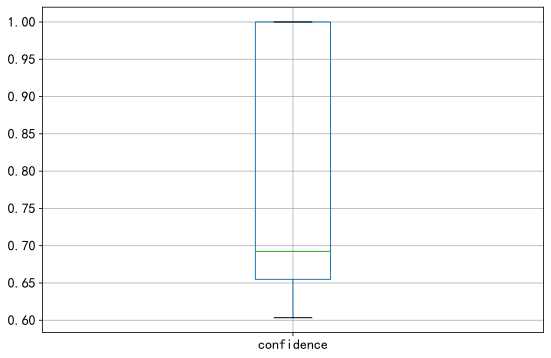

In [17]:
rules_eva["support"].plot.box(figsize=(9,6), fontsize=14 ,grid = True)
plt.show()
rules_eva["confidence"].plot.box(figsize=(9,6), fontsize=14 ,grid = True)
plt.show()

从直方图之中可以看出，这些评价方方在上述的12条发掘出的关联规则上面基本上是表现一致的。

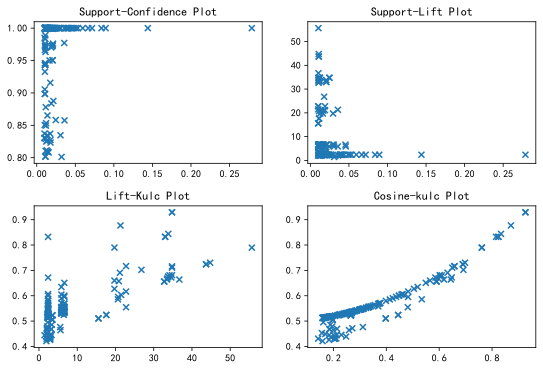

In [18]:
# 对更多关联规则进行可视化分析

mr_sup_antecedent = more_rules["antecedent support"]
mr_sup_consequent = more_rules["consequent support"]
mr_sup_co = more_rules["support"]
mr_confidence = more_rules["confidence"]

# kulc all_conf cosine 评价的计算
mr_rev_confidence = mr_sup_co / mr_sup_consequent
mr_all_conf = pd.DataFrame(list(zip(mr_confidence,mr_rev_confidence))).max(axis=1)
mr_kulc = (mr_confidence + mr_rev_confidence)/2
mr_consine = np.sqrt(mr_confidence * mr_rev_confidence)
more_rules["All_conf"] = mr_all_conf
more_rules["Kulc"] = mr_kulc
more_rules["Cosine"] = mr_consine

fig, ax1 = plt.subplots(figsize=(9, 6)) 

plt.subplots_adjust(hspace = 0.3)

plt.subplot(221)
plt.scatter(more_rules["support"],more_rules["confidence"] ,marker = 'x')
plt.title("Support-Confidence Plot")

plt.subplot(222)
plt.scatter(more_rules["support"],more_rules["lift"] ,marker = 'x')
plt.title("Support-Lift Plot")

plt.subplot(223)
plt.scatter(more_rules["lift"],more_rules["Kulc"] ,marker = 'x')
plt.title("Lift-Kulc Plot")

plt.subplot(224)
plt.scatter(more_rules["Cosine"],more_rules["Kulc"] ,marker = 'x')
plt.title("Cosine-kulc Plot")

plt.show()

从可视化结果之中我们可以看到高位的list通常对应于低位的sup，并且在这里筛选的大多数的规则都对应着高位的lift。另外一点值得注意的则是cosine与kulc似乎有着很好的相关性，这也代表着这样的评价方法似乎拥有着更加可靠的评价能力。

__Github:__  https://github.com/FadedFate/Data_Homeworkw2